# AllCTs

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Importing libraries

In [2]:
import os
import glob
import json

import torch
from torch.utils.data import Dataset
import torchio as tio

import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nrrd

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Getting data paths

In [8]:
input_folder = '../data/AllCTs/'
output_folder = '../data/AllCTs_nrrd_global/'
folder_names = [folder_name for folder_name in os.listdir(input_folder) if '.' not in folder_name]
folder_path = [os.path.join(input_folder, folder_name) for folder_name in folder_names]
folder_c_path = [os.path.join(folder_path[idx], f'{folder_name}_C.stl') for idx, folder_name in enumerate(folder_names)]
folder_m_path = [os.path.join(folder_path[idx], f'{folder_name}_M.stl') for idx, folder_name in enumerate(folder_names)]
zipped_path = list(zip(folder_c_path, folder_m_path))


## Analyzing statistics

### Calculating bounds

In [16]:
bounds = []
for idx, (c_path, m_path) in enumerate(zipped_path):
    print(f'Processing {idx+1}/{len(zipped_path)}')
    if os.path.exists(c_path) and os.path.exists(m_path):
        # Load meshes
        mesh_c = o3d.io.read_triangle_mesh(c_path)
        mesh_m = o3d.io.read_triangle_mesh(m_path)
        
        # Merge meshes
        merged_mesh = mesh_c + mesh_m

        # Create a scene and add the triangle mesh
        scene_mesh = o3d.t.geometry.TriangleMesh.from_legacy(merged_mesh)
        scene = o3d.t.geometry.RaycastingScene()
        _ = scene.add_triangles(scene_mesh)  # we do not need the geometry ID for mesh

        # Get the bounding box of the scene
        min_bound = scene_mesh.vertex.positions.min(0).numpy()
        max_bound = scene_mesh.vertex.positions.max(0).numpy()
        bounds.append((min_bound, max_bound))

Processing 1/946
Processing 2/946
Processing 3/946
Processing 4/946
Processing 5/946
Processing 6/946
Processing 7/946
Processing 8/946
Processing 9/946
Processing 10/946
Processing 11/946
Processing 12/946
Processing 13/946
Processing 14/946
Processing 15/946
Processing 16/946
Processing 17/946
Processing 18/946
Processing 19/946
Processing 20/946
Processing 21/946
Processing 22/946
Processing 23/946
Processing 24/946
Processing 25/946
Processing 26/946
Processing 27/946
Processing 28/946
Processing 29/946
Processing 30/946
Processing 31/946
Processing 32/946
Processing 33/946
Processing 34/946
Processing 35/946
Processing 36/946
Processing 37/946
Processing 38/946
Processing 39/946
Processing 40/946
Processing 41/946
Processing 42/946
Processing 43/946
Processing 44/946
Processing 45/946
Processing 46/946
Processing 47/946
Processing 48/946
Processing 49/946
Processing 50/946
Processing 51/946
Processing 52/946
Processing 53/946
Processing 54/946
Processing 55/946
Processing 56/946
P

In [17]:
bounds_array = np.array(bounds)
# Save the array to a file
np.save('../data/AllCTs/bounds_array.npy', bounds_array)

### Calculating global bounds

In [48]:
bounds_array = np.load('../data/AllCTs/bounds_array.npy')

In [49]:
# Get the minimum of the minimum bounds and the maximum of the maximum bounds
global_min_bound = np.amin(bounds_array[:, 0, :], axis=0)
global_max_bound = np.amax(bounds_array[:, 1, :], axis=0)

# The biggest bounding box
biggest_bbox = np.array([global_min_bound, global_max_bound])

print('Biggest bounding box:', biggest_bbox)

Biggest bounding box: [[ -86.90451 -117.31971  -98.27915]
 [  84.40348  119.54489  157.4383 ]]


In [52]:
bounds_array.shape

(946, 2, 3)

In [57]:
(global_max_bound - global_min_bound)

array([171.30798, 236.8646 , 255.71744], dtype=float32)

In [63]:
((global_max_bound - global_min_bound)/512)

array([0.3345859 , 0.46262616, 0.49944812], dtype=float32)

## Voxelizing meshes

In [9]:
output_folder = '../data/AllCTs_nrrd_global/'
filled_ratios = []
file_start = 'CTS74'
start = False

In [ ]:
for idx, (c_path, m_path) in enumerate(zipped_path):
    if folder_names[idx] == file_start:
        start = True
        print('!!!!Starting!!!!')
    print(f'Processing {idx+1}/{len(zipped_path)}')
    print(folder_names[idx], c_path, m_path)
    if start and os.path.exists(c_path) and os.path.exists(m_path):
        # Load meshes
        mesh_c = o3d.io.read_triangle_mesh(c_path)
        mesh_m = o3d.io.read_triangle_mesh(m_path)
        
        # Merge meshes
        merged_mesh = mesh_c + mesh_m

        # Create a scene and add the triangle mesh
        scene_mesh = o3d.t.geometry.TriangleMesh.from_legacy(merged_mesh)
        scene = o3d.t.geometry.RaycastingScene()
        _ = scene.add_triangles(scene_mesh)  # we do not need the geometry ID for mesh
        
        xyz_range = np.linspace(global_min_bound, global_max_bound, num=512)
        query_points = np.stack(np.meshgrid(*xyz_range.T), axis=-1).astype(np.float32)

        occupancy = scene.compute_occupancy(query_points)

        # Save the occupancy grid
        print('Writing to nrrd')
        save_path = os.path.join(output_folder, f"{folder_names[idx]}.nrrd")
        nrrd.write(save_path, occupancy.numpy())

## Looking at some data

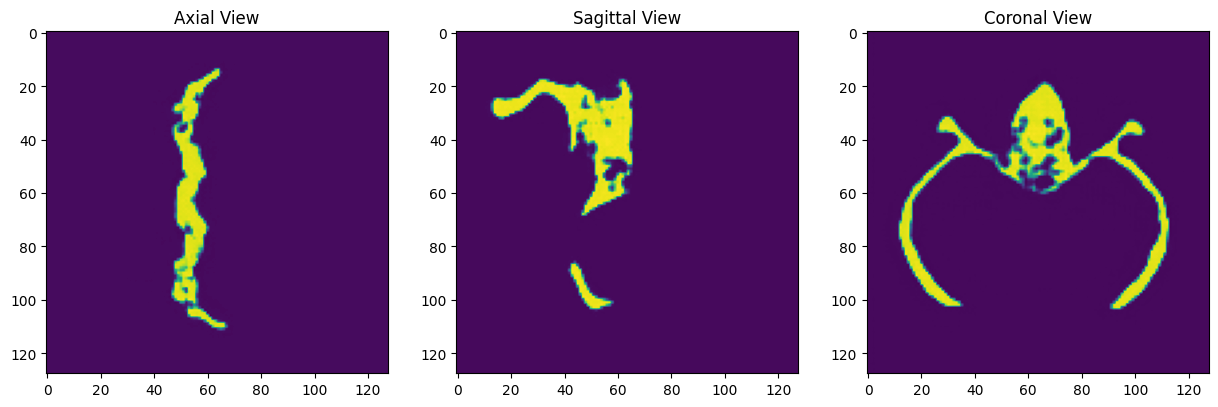

In [72]:
idx = 450

file_names = [file for file in os.listdir(output_folder) if file.endswith('.nrrd')]

file_names[idx] = 'ctg_44_q6.nrrd'
# Specify the path to the nrrd file
nrrd_file = os.path.join(output_folder, f'{file_names[idx]}')

# Read the nrrd file
data, header = nrrd.read(nrrd_file)

# Get the middle slice index
middle_slice = data.shape[0] // 2

# Plot the middle slice from different perspectives
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Axial view
axs[0].imshow(data[middle_slice, :, :])
axs[0].set_title('Axial View')

# Sagittal view
axs[1].imshow(data[:, middle_slice, :])
axs[1].set_title('Sagittal View')

# Coronal view
axs[2].imshow(data[:, :, middle_slice])
axs[2].set_title('Coronal View')

# Show the plot
plt.show()


## Rename files in folder to match name of splits

In [11]:
def rename_files(folder):
    # Get all .nrrd files in the folder
    files = glob.glob(os.path.join(
            folder, './**/*.nrrd'), recursive=True)

    for file in files:
        # Split the file path into folder, name and extension
        folder, name = os.path.split(file)
        base, ext = os.path.splitext(name)

        # Split the base into letters and number
        letters = base.rstrip('0123456789')
        number = base[len(letters):]

        # Rename the file
        new_name = '{}{:03}{}'.format(letters, int(number), ext)
        os.rename(file, os.path.join(folder, new_name))

In [12]:
rename_files(output_folder)

## Creating metadata.csv

In [63]:
raw_df = pd.read_csv('../data/allcts-global-128/metadata_raw.csv', sep=';')
# Remove where name is NaN
raw_df = raw_df[~raw_df['name'].isna()]
raw_df = raw_df[~raw_df['quality'].isna()]
raw_df

,name,quality,info
0,CTS000,5,NaN
1,CTS001,5,NaN
2,CTS002,5,NaN
3,CTS003,5,NaN
4,CTS004,3,short
...,...,...,...
940,CT484,1,NaN
941,CT485,5,NaN
942,CT486,4,NaN
943,CT488,4,NaN


Let's see how the quality score is distributed

In [65]:
raw_df['quality'].value_counts()

3       256
2       200
5       195
4       194
6        47
1        30
3.5       6
2.5       6
3,5       3
2,5       3
1.5       2
1.5       1
0         1
Name: quality, dtype: int64

As it is possible to see, there are some intermediate qualities that need to be fixed. To be conservative, I will XXX them to the lower integer.

In [66]:
quality_mapping = {
    '3.5': '3',
    '2.5': '2',
    '1.5': '1',
    '1.5 ': '1',
    '3,5': '3',
    '2,5': '2',
}

raw_df['quality'] = raw_df['quality'].replace(quality_mapping)
raw_df['quality'].value_counts()

3    265
2    209
5    195
4    194
6     47
1     33
0      1
Name: quality, dtype: int64

The first thing to do is to filter out CTs with score 1 or 0

In [67]:
filtered_df = raw_df[(raw_df['quality'] != '0') & (raw_df['quality'] != '1')]
print(filtered_df.shape)
filtered_df['quality'].value_counts()

(910, 3)


3    265
2    209
5    195
4    194
6     47
Name: quality, dtype: int64

Let's now explore the info values

In [68]:
filtered_df['info'].value_counts()

*           27
comp        12
* comp      11
part         8
*comp        8
cut ant      7
short        6
partial      3
v short      2
* short      2
*+           1
(bad)        1
*++          1
partial*     1
half         1
?            1
(*)          1
Name: info, dtype: int64

After analyzing the meaning of the labels we decided to remove some of these categories.

In [69]:
info_to_remove = ['(bad)']

filtered_df = filtered_df[~filtered_df['info'].isin(info_to_remove)]
filtered_df

,name,quality,info
0,CTS000,5,NaN
1,CTS001,5,NaN
2,CTS002,5,NaN
3,CTS003,5,NaN
4,CTS004,3,short
...,...,...,...
937,CT480,3,NaN
941,CT485,5,NaN
942,CT486,4,NaN
943,CT488,4,NaN


Now we have to divide the dataset in splits in a stratified fashion

In [73]:
# Split to train, val and test
# Stratify by quality
from sklearn.model_selection import train_test_split

train_df_index, val_test_df_index = train_test_split(filtered_df.index, test_size=0.2, stratify=filtered_df['quality'], random_state=42)

In [83]:
df = filtered_df.copy()
# Set the split column
df['split'] = 'train'
df['split'].loc[val_test_df_index] = 'test'
df

,name,quality,info,split
0,CTS000,5,NaN,train
1,CTS001,5,NaN,train
2,CTS002,5,NaN,train
3,CTS003,5,NaN,train
4,CTS004,3,short,train
...,...,...,...,...
937,CT480,3,NaN,test
941,CT485,5,NaN,train
942,CT486,4,NaN,train
943,CT488,4,NaN,train


Now we have to rename the cts all to have leading zeros up to 3 decimals

In [96]:
def rename(row):
    name = row['name']
    base, ext = os.path.splitext(name)

    # Split the base into letters and number
    letters = base.rstrip('0123456789')
    number = base[len(letters):]

    # Rename the file
    new_name = '{}{:03}{}'.format(letters, int(number), ext)
    row['name'] = new_name
    return row
    

df = df.apply(rename, axis=1)


Let's check if all the files listed are present in the folder

In [100]:
def is_absent(row):
    name = row['name']
    file_name = os.path.join('../data/allcts-global-128/', name + '.nrrd')
    return not os.path.exists(file_name)

df.apply(is_absent, axis=1).sum()

0

Since all the files are present we can go on and save the metadata

In [101]:
# Save df to csv
df.to_csv('../data/allcts-global-128/metadata.csv', sep=',', index=False)

We will not integrate these files because they are qualitatively not good enough to be used for training

## Add filled ratio to df

In [36]:
# Function to compute the filled_ratio for a given name
def compute_filled_ratio(name):
    # Load the occupancy grid
    occupancy, _ = nrrd.read(os.path.join(output_folder, f"{name}.nrrd"))
    # Calculate the filled volume
    filled_volume = np.count_nonzero(occupancy)
    # Calculate and return the filled ratio
    return filled_volume / 134217728

0.06199205666780472

In [39]:
# Apply the function to the 'name' column and add the results as a new column
import multiprocessing as mp

# Create a pool of processes
with mp.Pool(mp.cpu_count()) as pool:
    # Apply the function to each row in parallel
    df['filled_ratio'] = pool.map(compute_filled_ratio, df['name'])

pool.close()
pool.join()

print(df)

In [11]:
output_path = os.path.join(output_folder, 'metadata.csv')
df.to_csv(output_path, index=False)


In [10]:
print(output_path)

../data/AllCTs_nrrd_global/metadata.csv


In [ ]:
ratios = [] # List of tuples (folder_name, qs, filled_ratio)
for idx, folder_name in enumerate(folder_names):
    print(f'Processing {idx+1}/{len(folder_names)}')
    if os.path.exists(os.path.join(output_folder, f"{folder_name}.nrrd")):
        # Load the occupancy grid
        occupancy, _ = nrrd.read(os.path.join(output_folder, f"{folder_name}.nrrd"))
        # Calculate the filled volume
        filled_volume = np.count_nonzero(occupancy)
        filled_ratio = filled_volume / 134217728
        ratios.append((folder_name, filled_ratio))


## Dataset inspection

In [7]:
df[df.name < 'CTS']

,name,quality,info,split
568,CT000,3,NaN,train
569,CT002,4,NaN,test
570,CT003,2,NaN,train
571,CT004,4,NaN,train
572,CT006,5,NaN,train
...,...,...,...,...
904,CT480,3,NaN,test
905,CT485,5,NaN,train
906,CT486,4,NaN,train
907,CT488,4,NaN,train


<Figure size 3000x200 with 0 Axes>

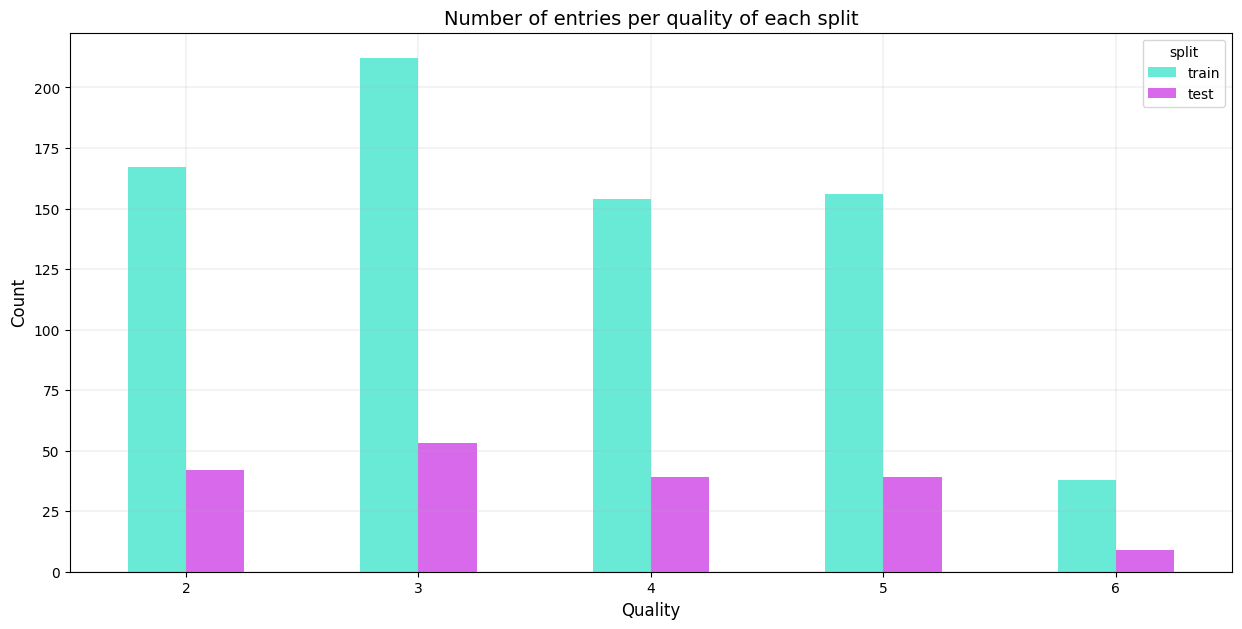

In [104]:
from IPython.core.pylabtools import figsize
figsize(15, 7)
# Set the figure size
plt.figure(figsize=(30, 2))

# Create the bar plot
quality_counts.plot(kind='bar', width=0.5, stacked=False, color=['#69ead7', '#d769ea', '#ead769'])

# Add gridlines
plt.grid(linewidth=0.2)

# Add title and labels
plt.title('Number of entries per quality of each split', fontsize=14)
plt.xlabel('Quality', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=0)

# Show the plot
plt.show()

## Creating qs metadata

In [8]:
name_dataset = 'filt-gen-05'

df = pd.read_csv(f'../data/{name_dataset}/metadata.csv')

# Count the number of entries per quality of each split
quality_counts = df.groupby(['quality', 'split']).size().unstack()
#quality_counts = quality_counts[['train', 'test']]
print(quality_counts)
print(quality_counts.sum())


split    train
quality       
2          167
3          212
4          154
5          156
6           38
split
train    727
dtype: int64


In [9]:
for i in range(5):
    df_quality = df.loc[df['quality'] == i+2]
    path = f'../data/{name_dataset}/metadata{i+2}.csv'
    df_quality.to_csv(path, index=False)
    print(f'Quality {i+2} saved to {path}')

Quality 2 saved to ../data/filt-gen-05/metadata2.csv
Quality 3 saved to ../data/filt-gen-05/metadata3.csv
Quality 4 saved to ../data/filt-gen-05/metadata4.csv
Quality 5 saved to ../data/filt-gen-05/metadata5.csv
Quality 6 saved to ../data/filt-gen-05/metadata6.csv


In [11]:
import wandb

# Provide your entity and a project name when you
# use wandb.Api methods.
api = wandb.Api(overrides={"project": "medicaldiffusion", "entity": "chavelanda"})

artifact_type, artifact_name = "model", 'model-l36ffu0v'  # provide type and name
for v in api.artifact_versions(artifact_type, artifact_name):
    # Clean up versions that don't have an alias such as 'latest'.
    # NOTE: You can put whatever deletion logic you want here.
    if len(v.aliases) == 0:
        v.delete()

## Testing dataset

In [3]:
from dataset import AllCTsDataset

In [12]:
dataset = AllCTsDataset(
    root_dir='../data/allcts-global-128/',
    metadata_name='metadata.csv',
    binarize=True,
)

In [13]:
img = dataset[0]['data']

In [14]:
torch.sum(img == -1) + torch.sum(img == 1)

tensor(2097152)

In [15]:
128*128*128 - torch.sum(img == -1) - torch.sum(img == 1)

tensor(0)